In [41]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
import pymc3 as pm
import pandas as pd
import seaborn as sns
import pymc3.sampling as sampling
import theano.tensor as tt

## Portfolio optimisation

Demiguel Nogalwes 2009 ran a model as followed:

We will assume the true asset-return distribution is given as $$G = 99\% \times \mathcal{N}(\mu,\Sigma) + 1\% \times D $$
where $D = \mathcal{N}(\mu_d,\Sigma_d)$ where $\Sigma_d=\Sigma$

Lim et al used the follow model:
$$ \mathbf{X} \sim \mathcal{N}(\mathbf{\mu},\mathbf{\Sigma})$$

</p>Given $N$ risky assets the mean variance portfolio is the solution to the problem 
$$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w} - \frac{1}{\gamma}\hat{\mathbf{\mu}}^T\mathbf{w}$$ 
$$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

<p> We also seek to find the minimum-variance porfolio 
    $$\min_w \mathbf{w}^T\hat{\Sigma}\mathbf{w}$$
    $$s.t. \mathbf{w}^T\mathbf{e} = 1 $$</p>

In [2]:
mu = np.array([26.11 , 25.21 , 28.90 , 28.68 , 24.18])*10e-4
covar = np.array([[3.715 , 3.730 , 4.420 , 3.606 , 3.673],
                 [3.730 , 3.908 , 4.943 , 3.732 , 3.916],
                [4.420 , 4.943 , 8.885 , 4.378 , 5.010],
                  [3.606 , 3.732 , 4.378 , 3.930 , 3.789],
                  [3.673 , 3.916 , 5.010 , 3.789 , 4.027]])*10e-4
model = st.multivariate_normal(mean=mu,cov=covar)

In [3]:
def mean_variance(weights,mean,cov,gamma,average=False):
    var = np.dot(np.dot(weights,cov_est),weights)
    mean = 1.0/gamma*np.dot(mean,weights)
    if average:
        return np.mean(var-mean,axis=0)
    else: 
        return var-mean

In [4]:
def sum_weights(weights):
    return np.sum(weights)-1

In [5]:
init_weights = np.ones((5))/5
gamma = [0.1,1.0,5.0,10]
N = [50,100,200]
constraints = [{'type':'eq','fun':sum_weights}]
n_iter = 1000
df = pd.DataFrame(columns=['w_star','method','gamma','N'])

In [83]:
def mle_mv_gaussian(samples,gamma):
    cov_est = np.cov(np.transpose(samples))
    mean_est = np.mean(samples,axis=0)
    res = minimize(mean_variance,init_weights,args=(mean_est,cov_est,gamma,
                                                    False),
                  constraints=constraints,
                  bounds=[(0,None)]*5)
    return res.x

In [6]:
def fix_string(x):
    return np.array([float(z) for z in x[1:-1].split(' ') if z is not ""])

In [7]:
df = pd.read_csv("portfolio_opt.csv",index_col=0)

In [8]:
df['w_star'] = df['w_star'].apply(lambda x:fix_string(x))
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(mu,x))

In [9]:
df[df['method']=='True']

,w_star,method,gamma,N,expected_return
3000,"[3.97205465e-16, 0.0, 0.240396728, 0.759603272...",True,0.1,200,0.028733
6001,"[1.94289029e-16, 0.0, 0.0, 1.0, 1.16226473e-16]",True,1.0,200,0.028680
9002,"[0.360456875, 0.0948441679, 4.33680869e-17, 0....",True,5.0,200,0.027425
12003,"[0.282611182, 0.226234045, 5.55111512e-17, 0.2...",True,10.0,200,0.026257


In [10]:
gamma_df = df[df['gamma']==10.0]

/home/harrison/.virtualenvs/python3/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


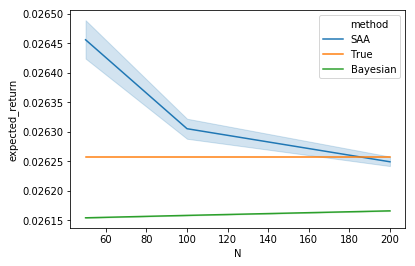

In [11]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

## Using Bayesian inference

We use a normal-inversewishart prior on the mean and covariance of the multivariate gaussian.

$$p(\mu|\Sigma)\sim \mathcal{N}(27*10^{-4},10^{-4}\Sigma)$$
$$p(\Sigma)\sim \mathcal{W}^{-1}(\mathbf{I},1)$$


In [12]:
mu0 = np.array([27e-3]*5)
m =1/10e-4
Psi = np.eye(5)
nu0 = 5

In [85]:
def bayesian_portfolio(samples,n_samples=5000):
    # known scaling
    with pm.Model() as model:
        sd_dist = pm.HalfCauchy.dist(beta=2.5)
        chol_dist = pm.LKJCholeskyCov('chol',n=5,eta=2,
                                      sd_dist=sd_dist)
        chol = pm.expand_packed_triangular(5, chol_dist, lower=True)
        mu_dist = pm.MvNormal('mu',chol=chol, mu=mu0,shape=5)
        observed = pm.MvNormal('obs',mu=mu_dist,chol=chol,observed=samples)
        # Using Metropolis Hastings Sampling
        step = pm.Metropolis()

        # Sample from the posterior using the sampling method
        trace = pm.sample(n_samples, step=step, njobs=4,progressbar=False,cores=4)
        
        new_samples = np.reshape(sampling.sample_ppc(trace,samples=n_samples,
                    model=model,
                    progressbar=False)['obs'],(-1,5))    
    return new_samples

In [89]:
n_iter = 2000

In [90]:
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            samples = model.rvs(N[i])
            new_samples = bayesian_portfolio(samples)
            res_x = mle_mv_gaussian(new_samples,gamma[j])
            
            results = {'w_star': res_x,'method':'Bayes_new','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did n

OSError: [Errno 12] Cannot allocate memory

In [ ]:
n_iter=1000

In [ ]:
df = pd.read_csv("portfolio_opt.csv",index_col=0)

In [ ]:
new_samples = []
for j in range(len(gamma)):
    for l in range(n_iter):
        for i in range(len(N)):
            n = N[i]
            samples = model.rvs(n)
            sample_mean = np.mean(samples,axis=0)
            sample_cov = np.cov(samples.T)
            posterior_sigma_scale = Psi+n*sample_cov+m*n/(n+m)*np.dot((sample_mean-mu0).T,
                                                                  sample_mean-mu0)
            posterior_sigma_nu = n+nu0
            cov_array = []
            mean_array = []
            for k in range(2000):

                cov_array.append(st.invwishart.rvs(
                                scale=posterior_sigma_scale,
                                df=posterior_sigma_nu))
                posterior_mean_mu = (n*sample_mean+m*mu0)/(m+n)
                #mean_wishart = posterior_sigma_scale/(posterior_sigma_nu-sample_mean.shape[0]-1)
                posterior_mean_sigma = 1/(m+n)*cov_array[k]
                mean_array.append(st.multivariate_normal.rvs(posterior_mean_mu,
                                                            posterior_mean_sigma))
            res = minimize(mean_variance,
                            init_weights,
                            args=(mean_array,
                                  cov_array,
                                    gamma[j],
                                     True),
                          constraints=constraints,
                          bounds=[(0,None)]*5)
            results = {'w_star': res.x,'method':'Bayesian','gamma':gamma[j],'N':N[i]}
            df = df.append(results,ignore_index=True)
            

In [97]:
df['expected_return'] = df['w_star'].apply(lambda x:np.dot(
                                            mu,x))

In [91]:
df.to_csv("portfolio_opt.csv")

In [107]:
gamma_df = df[df['gamma']==0.5]

IndexError: single positional indexer is out-of-bounds

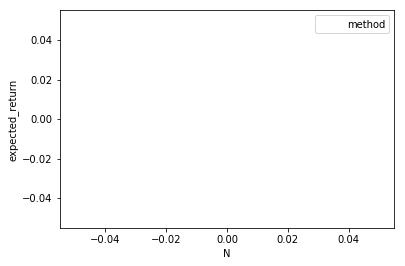

In [108]:
ax = sns.lineplot(x=gamma_df['N'], y=gamma_df['expected_return'], 
                  hue=gamma_df['method'])
plt.plot(N,[gamma_df[gamma_df['method']=='True']['expected_return'].iloc[0]]*3)

In [98]:
df.head()

,w_star,method,gamma,N,expected_return
0,"[2.47191542e-16, 3.95550517e-16, 0.0, 1.0, 2.4...",SAA,0.1,50,0.02868
1,"[0.0, 0.0, 1.04083409e-16, 1.0, 0.0]",SAA,0.1,100,0.02868
2,"[2.56820023e-16, 1.07459673e-16, 1.0, 0.0, 0.0]",SAA,0.1,200,0.02890
3,"[2.48253415e-17, 0.0, 3.60822483e-16, 1.0, 0.0]",SAA,0.1,50,0.02868
4,"[1.1908406e-16, 0.0, 5.42456534e-16, 1.0, 2.33...",SAA,0.1,100,0.02868
